# ObsID : 0945020132, SRCNUM : 7, Instru : EPN

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from astropy.io import fits
from astropy.stats import poisson_conf_interval

import stingray as st
from stingray import Lightcurve, AveragedPowerspectrum
from stingray.pulse.pulsar import fold_events
from stingray.pulse.search import plot_profile
from stingray.pulse.search import epoch_folding_search, z_n_search
from stingray.gti import create_gti_mask
from stingray.pulse.search import search_best_peaks
from stingray.stats import fold_detection_level, z2_n_detection_level

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

plt.rcParams['figure.figsize'] = [10,5]

## Light curve

In [11]:
def periodicity(file, gtis, max_gti):
    hdul = fits.open(file)
    print()
    print(color.BOLD +file+ color.END)
    hdul.info()
    
    rate_data = hdul[1].columns
    print()
    print(rate_data)
        
    time = hdul[1].data.field('TIME')
    rate = hdul[1].data.field('RATE')
    error = hdul[1].data.field('ERROR')
    backrate = hdul[1].data.field('BACKV')
    
    lcs = []
    backlcs = []
    lcs.append(Lightcurve(time, rate, error, gti=gtis, input_counts=False))
    backlcs.append(Lightcurve(time, backrate, error, gti=gtis, input_counts=False))
    
    for i in range(len(lcs)):
        plt.xlabel('Time (s)')
        plt.ylabel('Countrate (/s)')
        plt.plot(lcs[i].time, lcs[i].countrate, color='steelblue', lw=1, ds='steps-mid', label='Source')
        plt.plot(backlcs[i].time, backlcs[i].countrate, color='firebrick',lw=1, ls='--', ds='steps-mid', label='Background')
        plt.title(f'ObsID : 0945020132, SRCNUM : 7, Instru : EPN')
        plt.legend(loc='upper right')
        plt.grid()
        for j in range(len(lcs[i].gti)-1):
            plt.axvspan(lcs[i].gti[j][1],lcs[i].gti[j+1][0],color='purple',alpha=0.25)
        plt.show()

    avg_ps = AveragedPowerspectrum(lcs[0],segment_size=max_gti)
    
    def linear_fit(log_freq, slope, intercept):
        return slope * log_freq + intercept

    valid = (avg_ps.freq > 0) & (avg_ps.power > 0)
    log_freq = np.log10(avg_ps.freq[valid])
    log_power = np.log10(avg_ps.power[valid])

    params, _ = curve_fit(linear_fit, log_freq, log_power)
    slope, intercept = params
    
    # Ligne ajustée
    fitted_line = 10**(slope * log_freq + intercept)
    
    plt.plot(avg_ps.freq, avg_ps.power, lw=1, color='steelblue', label="Averaged PSD")
    plt.loglog(10**log_freq, fitted_line, color='firebrick', linestyle='--', lw=1, label=f"Fit: y={slope:.2f}x+{intercept:.2f}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (/rms)")
    plt.title(f'ObsID : 0945020132, SRCNUM : 7, Instru : EPN')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [15]:
def periodicity_rebin(file, gtis, max_gti, dt_rebin):
    hdul = fits.open(file)
    time = hdul[1].data.field('TIME')
    rate = hdul[1].data.field('RATE')
    error = hdul[1].data.field('ERROR')
    backrate = hdul[1].data.field('BACKV')
    
    lcs = []
    lc = Lightcurve(time, rate, error, gti=gtis, input_counts=False)
    lcs.append(lc.rebin(dt_rebin))
    
    for i in range(len(lcs)):
        plt.xlabel('Time (s)')
        plt.ylabel('Countrate (/s)')
        plt.plot(lcs[i].time, lcs[i].countrate, color='steelblue', lw=1, ds='steps-mid', label='Source')
        plt.title(f'Time bin size : {dt_rebin}s')
        plt.legend(loc='upper right')
        plt.grid()
        for j in range(len(lcs[i].gti)-1):
            plt.axvspan(lcs[i].gti[j][1],lcs[i].gti[j+1][0],color='purple',alpha=0.25)
        plt.show()

    avg_ps = AveragedPowerspectrum(lcs[0],segment_size=max_gti)
    
    def linear_fit(log_freq, slope, intercept):
        return slope * log_freq + intercept

    valid = (avg_ps.freq > 0) & (avg_ps.power > 0)
    log_freq = np.log10(avg_ps.freq[valid])
    log_power = np.log10(avg_ps.power[valid])

    params, _ = curve_fit(linear_fit, log_freq, log_power)
    slope, intercept = params
    
    # Ligne ajustée
    fitted_line = 10**(slope * log_freq + intercept)
    
    plt.plot(avg_ps.freq, avg_ps.power, lw=1, color='steelblue', label="Averaged PSD")
    plt.loglog(10**log_freq, fitted_line, color='firebrick', linestyle='--', lw=1, label=f"Fit: y={slope:.2f}x+{intercept:.2f}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (/rms)")
    plt.title(f'Time bin size : {dt_rebin}s')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [17]:
def gtis(file):
    hdul = fits.open(file)
    gtis = []
    max_gti = 0
    for i in hdul[2].data:
        gtis.append([i[0],i[1]])
        if i[1] - i[0] > max_gti:
            max_gti = i[1] - i[0]
    print("max gti :", max_gti)
    return gtis, max_gti

max gti : 8748.320000052452

P0945020132PNS003SRCTSR8007.FTZ
Filename: P0945020132PNS003SRCTSR8007.FTZ
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      67   ()      
  1  RATE          1 BinTableHDU    102   5992R x 6C   [D, E, E, E, E, E]   
  2  SRC_GTIS      1 BinTableHDU     28   1R x 2C   [D, D]   
  3  BKG_GTIS      1 BinTableHDU     28   1R x 2C   [D, D]   
  4  REGION_SRC    1 BinTableHDU     23   1R x 4C   [16A, E, E, E]   
  5  REGION_BKG    1 BinTableHDU     23   2R x 4C   [16A, E, E, E]   

ColDefs(
    name = 'TIME'; format = 'D'; unit = 's'
    name = 'RATE'; format = 'E'; unit = 'count/s'
    name = 'ERROR'; format = 'E'; unit = 'count/s'
    name = 'FRACEXP'; format = 'E'; unit = 'fraction'
    name = 'BACKV'; format = 'E'; unit = 'count/s'
    name = 'BACKE'; format = 'E'; unit = 'count/s'
)


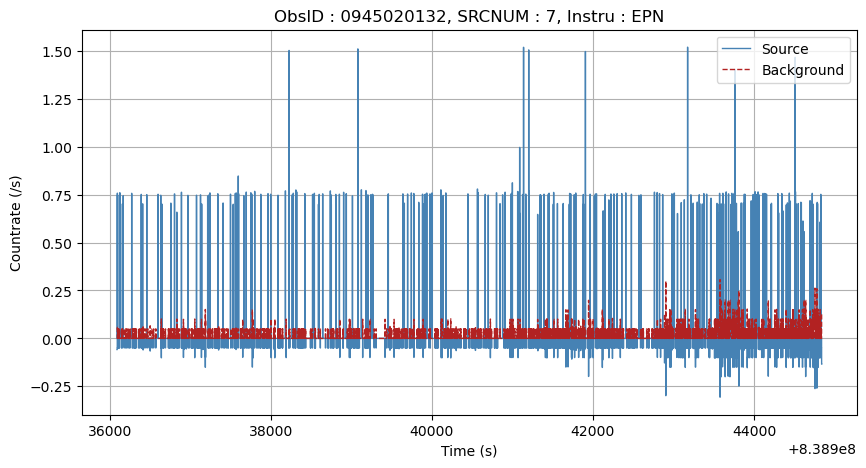

1it [00:00, 813.80it/s]


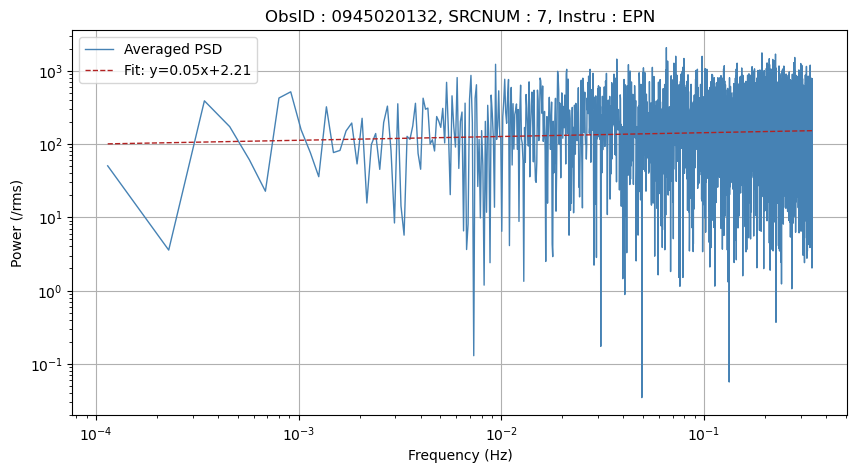

In [19]:
lc_fname = "P0945020132PNS003SRCTSR8007.FTZ"
gtis, max_gti = gtis(lc_fname)
periodicity(lc_fname, gtis, max_gti)

### Time bin size = 10s

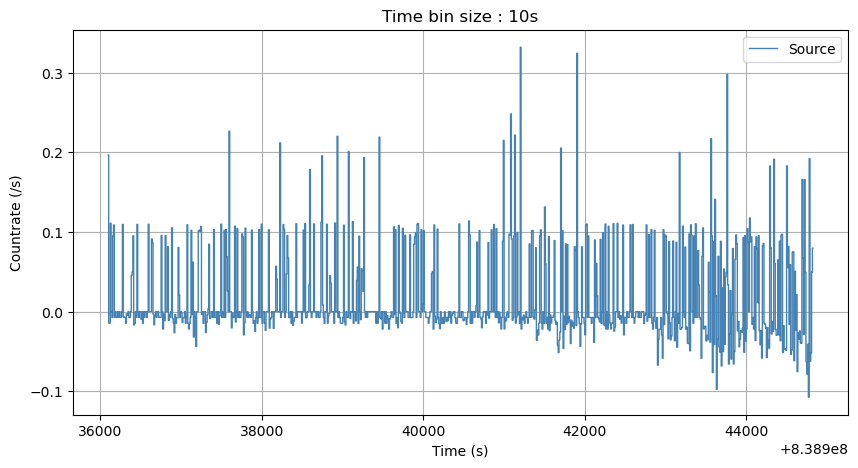

1it [00:00, ?it/s]


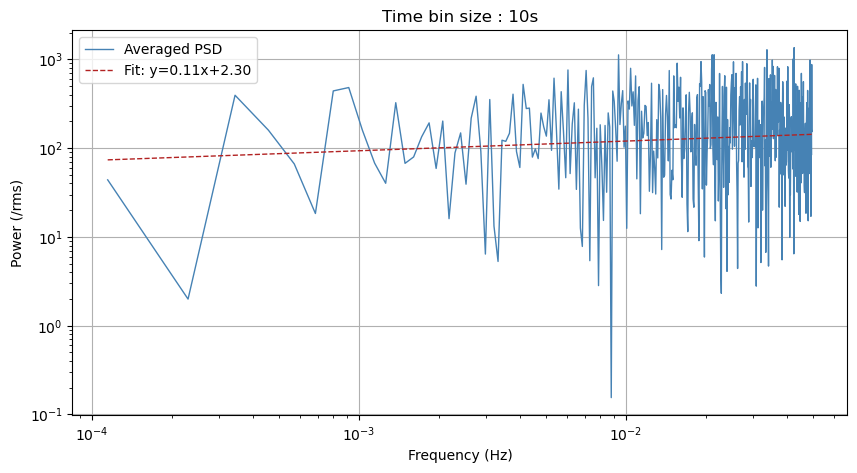

In [26]:
periodicity_rebin(lc_fname, gtis, max_gti, 10)

### Time bin size = 50s

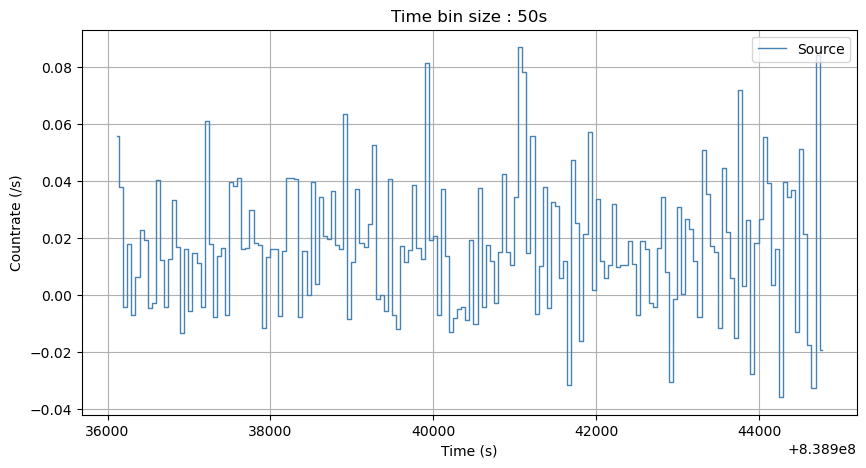

1it [00:00, 684.00it/s]


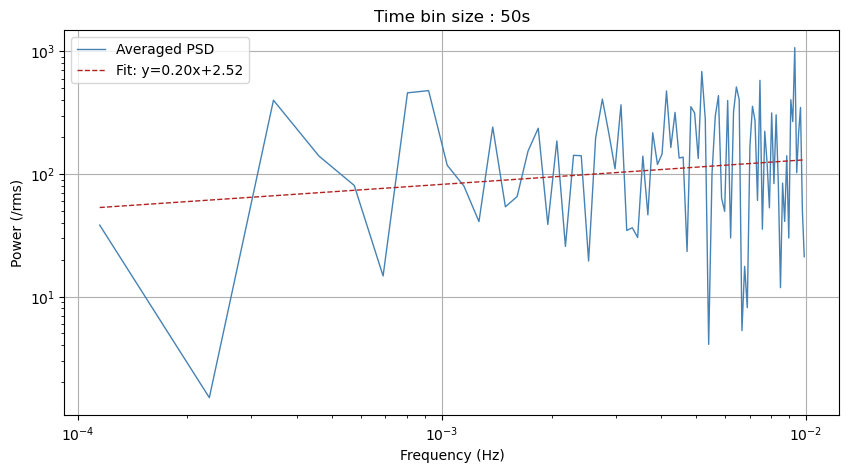

In [28]:
periodicity_rebin(lc_fname, gtis, max_gti, 50)

### Time bin size = 200s

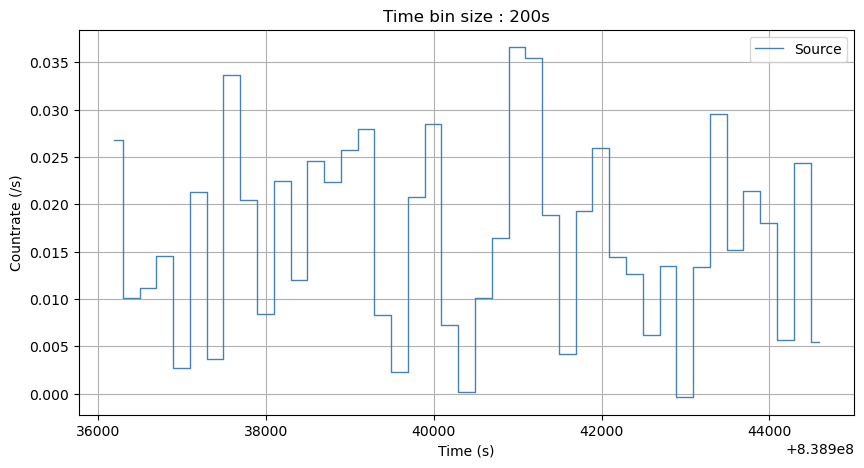

1it [00:00, 145.91it/s]


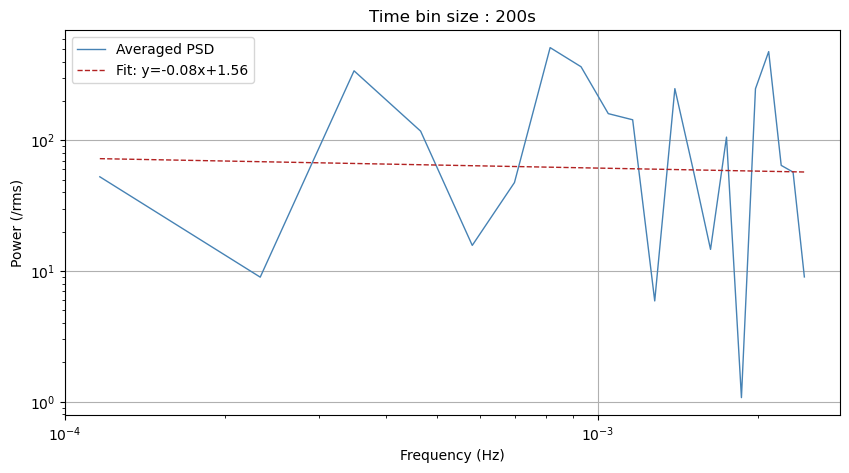

In [30]:
periodicity_rebin(lc_fname, gtis, max_gti, 200)

### Time bin size = 500s

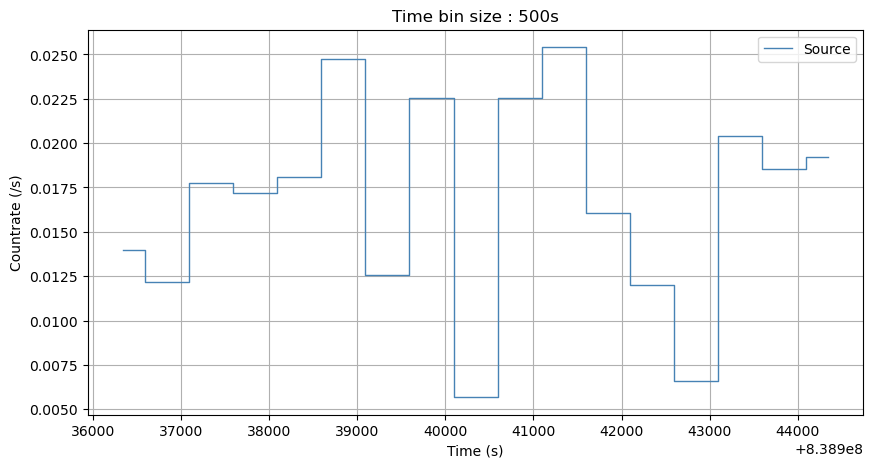

1it [00:00, ?it/s]


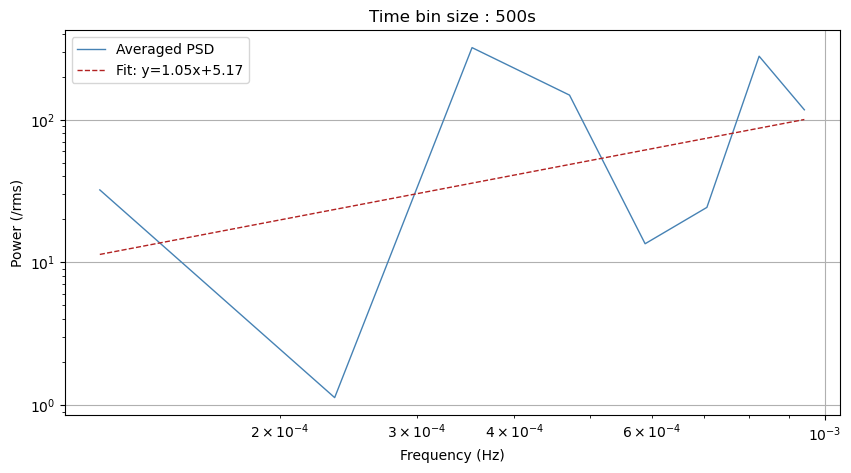

In [32]:
periodicity_rebin(lc_fname, gtis, max_gti, 500)

## Event list